# REGRESSION

This section is divided in four main sections:
- Models originally applied on the orginal dataset
- Models applied on the grouped dataset
- Models applied on the original dataset using the GroupShufflesplit 
- Models applied on the grouped dataset with StratifiedShuffleSplit

### IMPORTING LIBRARIES

In [5]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
import yellowbrick
import shap
import xgboost as xgb
import vaex.ml
from scipy import stats
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler, LabelEncoder, PolynomialFeatures, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import LinearRegression, Ridge, PoissonRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error, r2_score
from bayes_opt import BayesianOptimization

## REGRESSION ON THE ORIGINAL DATASET

### IMPORTING DATASET

In [10]:
pd.set_option('display.max_columns',None)
df = pd.read_csv("SupplyChainDataset.csv")

### PREPROCESSING

For the preprocessing we have created two classes in order  to process the data for machine learning models (These classes are the same as in the classification problem, with some adjustments)

In [11]:
class PreprocessDataFrame:
    def __init__(self,df):
        self.df = df

    def parse_column_names(self):
        self.df.columns = [i.replace(' ','_').replace('(','').replace(')','') for i in self.df.columns]
        return self.df
    
    #def drop_days_of_delay(self):
    #    self.df = self.df[(self.df.Delivery_Status_Shipping != 'canceled')]
     #   return self.df
    
    #Dropping columns that are about personal info, 
    #Dropping columns that have a 1:1 correlation with another variable 
    #Dropping columns that provides info about the future
    #Dropping columns that do not provide useful information
    
    def drop_unuseful_columns(self):
        to_drop = ['Customer_Country', 'Customer_Email', 'Customer_Fname', 'Customer_Id',
                   'Customer_Lname', 'Customer_Password', 'Customer_Street', 'Customer_Zipcode', 'Order_Item_Discount_Rate',
                   'Product_Description', 'Product_Image', 'Product_Status', 'Order_Zipcode', 'Order_Item_Id', 'Order_Item_Discount',
                   'Order_Country', 'Order_Customer_Id', 'Order_Country', 'Order_Region', 'Order_State', 'Sales_per_customer',
                   'Market', 'Customer_State', 'Order_Id', 'Order_Item_Cardprod_Id', 'Product_Card_Id', 'Category_Department_Name',
                   'Order_Profit_Per_Order','Department_Id','Product_Price','Category_Id', 'Delivery_Status', 'Late_delivery_risk', 'Order_Item_Product_Price']

        self.df['Category_Department_Name'] = (self.df['Category_Name'] + '_' + self.df['Department_Name']) \
            .str.replace(' ', '_')

        self.df = self.df.drop(to_drop + ['Category_Name','Department_Name'], axis=1)
        return self.df

    def process_datetetimes(self):
        self.df.shipping_date_DateOrders = pd.to_datetime(self.df.shipping_date_DateOrders)
        (self.df.shipping_date_DateOrders.astype(np.int64) / int(1e6)).astype('int64')

        self.df.order_date_DateOrders = pd.to_datetime(self.df.order_date_DateOrders)
        (self.df.order_date_DateOrders.astype(np.int64) / int(1e6)).astype('int64')
        return self.df
    
    #Function that create new columns about Source and Source Centrality
    def augment_with_network_features(self):
        self.df['Source'] = ('LA' + self.df['Latitude'].astype('str') + '-' + 'LO' + self.df['Longitude'].astype('str'))
        G = nx.from_pandas_edgelist(self.df, source='Source', target='Order_City')
        self.df['Source_Centrality'] = self.df.Source.map(dict(G.degree))
        return self.df

In [12]:
class DataframeProcessor_regression:

    def __init__(self):
        self.columns_for_ml = ['Type','Benefit_per_order',"Customer_City",
                               'Customer_Segment','Latitude','Longitude','Order_City',
                               'Order_Item_Profit_Ratio','Order_Item_Quantity',
                               'Sales','Order_Item_Total','Product_Category_Id', 'Product_Name',
                               'Shipping_Mode','Source_Centrality',
                               'Order_Month','Order_Day','Order_Weekday', 'Days_for_shipping_real']

    def process_df_for_regression(self, df):
        df['order_date_DateOrders'] = pd.to_datetime(df['order_date_DateOrders'], unit='ms')

        df['Order_Month'] = df.order_date_DateOrders.dt.month
        df['Order_Day'] = df.order_date_DateOrders.dt.day
        df['Order_Weekday'] = df.order_date_DateOrders.dt.dayofweek

        ml = df[self.columns_for_ml]
        return ml

    def cycletransform_month_day_weekday(self,df):
        
        ml = vaex.from_pandas(df=df, copy_index=False)
        ml = vaex.ml.CycleTransformer(features=['Order_Month'], n=12).fit_transform(ml)
        ml = vaex.ml.CycleTransformer(features=['Order_Day'], n=31).fit_transform(ml)
        ml = vaex.ml.CycleTransformer(features=['Order_Weekday'], n=7).fit_transform(ml)
        ml = ml.to_pandas_df()
        return ml

    def return_processed_and_split_X_y(self,df):
        X = df[[i for i in df.columns if i != 'Days_for_shipping_real']]
        X = X.drop(['Order_Month','Order_Day','Order_Weekday'],axis=1)
        y = df['Days_for_shipping_real']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        return X_train, X_test, y_train, y_test

    @staticmethod
    def encode_Xtrain_Xtest(X_train,X_test):

        X_train = vaex.from_pandas(df=X_train, copy_index=False)
        X_test = vaex.from_pandas(df=X_test, copy_index=False)
        ohe = vaex.ml.OneHotEncoder(features=["Type", "Customer_Segment",'Shipping_Mode'])
        X_train = ohe.fit_transform(df=X_train)
        X_test = ohe.transform(X_test)

        mhe = vaex.ml.MultiHotEncoder(features=["Order_City","Customer_City"])
        X_train = mhe.fit_transform(df=X_train)
        X_test = mhe.transform(X_test)

        X_train = X_train.to_pandas_df()
        X_test = X_test.to_pandas_df()

        X_train = X_train[X_train.dtypes[X_train.dtypes != 'object'].index.tolist()]
        X_test = X_test[X_test.dtypes[X_test.dtypes != 'object'].index.tolist()]

        return X_train, X_test

#read the original data
df_original = df.copy()
#apply the PreprocessDataFrame class and its related functions. 
#preprocessor = PreprocessDataFrame(df_original).drop_days_of_delay()
preprocessor = PreprocessDataFrame(df_original).parse_column_names()
preprocessor = PreprocessDataFrame(preprocessor).drop_unuseful_columns()
preprocessor = PreprocessDataFrame(preprocessor).process_datetetimes()
preprocessor = PreprocessDataFrame(preprocessor).augment_with_network_features() #This class add the 'Source_Centrality' measure, which rely on networkz built-in function to compute the 
#importance of the source (the Stores, as identified by their lat and long features') on the targets (the order cities). 

#apply the class for the dataframe processor for the models
cdp = DataframeProcessor_regression()
df_class = cdp.process_df_for_regression(preprocessor)
df_class = cdp.cycletransform_month_day_weekday(df_class)
X_train, X_test, y_train, y_test = cdp.return_processed_and_split_X_y(df_class)
X_train, X_test = cdp.encode_Xtrain_Xtest(X_train, X_test)

In [13]:
X_train

,Benefit_per_order,Latitude,Longitude,Order_Item_Profit_Ratio,Order_Item_Quantity,Sales,Order_Item_Total,Product_Category_Id,Source_Centrality,Order_Month_x,Order_Month_y,Order_Day_x,Order_Day_y,Order_Weekday_x,Order_Weekday_y,Type_CASH,Type_DEBIT,Type_PAYMENT,Type_TRANSFER,Customer_Segment_Consumer,Customer_Segment_Corporate,Customer_Segment_Home Office,Shipping_Mode_First Class,Shipping_Mode_Same Day,Shipping_Mode_Second Class,Shipping_Mode_Standard Class,Order_City_0,Order_City_1,Order_City_2,Order_City_3,Order_City_4,Order_City_5,Order_City_6,Order_City_7,Order_City_8,Order_City_9,Order_City_10,Order_City_11,Order_City_12,Customer_City_0,Customer_City_1,Customer_City_2,Customer_City_3,Customer_City_4,Customer_City_5,Customer_City_6,Customer_City_7,Customer_City_8,Customer_City_9,Customer_City_10
0,107.989998,29.737015,-94.968758,0.48,1,299.980011,224.990005,43,33,8.660254e-01,-5.000000e-01,0.820763,-5.712682e-01,1.000000,0.000000,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1
1,53.200001,29.380371,-98.642235,0.13,1,399.980011,399.980011,45,28,8.660254e-01,-5.000000e-01,0.820763,5.712682e-01,0.623490,0.781831,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0
2,-71.970001,18.268999,-66.370499,-0.80,2,99.959999,89.959999,46,9,6.123234e-17,1.000000e+00,0.347305,-9.377521e-01,-0.222521,0.974928,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1
3,14.400000,18.200861,-66.370529,0.08,1,199.990005,191.990005,48,6,6.123234e-17,1.000000e+00,1.000000,-2.449294e-16,-0.900969,-0.433884,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1
4,65.190002,39.958561,-75.218887,0.16,4,399.959992,399.959992,9,33,-1.836970e-16,-1.000000e+00,0.979530,2.012985e-01,0.623490,0.781831,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120942,50.439999,18.200050,-67.140244,0.26,1,199.990005,193.990005,48,45,-1.000000e+00,1.224647e-16,0.151428,-9.884683e-01,-0.222521,0.974928,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,0,1,1,0,0,0,1
120943,33.080002,18.236956,-66.370575,0.35,2,100.000000,94.500000,24,10,6.123234e-17,1.000000e+00,0.918958,-3.943559e-01,0.623490,0.781831,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1
120944,22.610001,18.239336,-66.370514,0.13,2,199.979996,169.979996,9,4,8.660254e-01,5.000000e-01,-0.250653,9.680771e-01,-0.222521,-0.974928,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,1,1
120945,83.699997,33.205608,-97.138359,0.46,5,199.949997,181.949997,29,19,5.000000e-01,-8.660254e-01,-0.758758,6.513725e-01,1.000000,0.000000,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0


### MODELS

### Poisson Regression

In [14]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()

numeric_pipeline = Pipeline(steps = [
    ('minmax', MinMaxScaler())
    #('poly', PolynomialFeatures())
])

full_processor = ColumnTransformer([
     ('number', numeric_pipeline, numerical_features)])
    
pr = PoissonRegressor(alpha=0, fit_intercept=False, solver='lbfgs', max_iter=1000)

# set up pipeline
pr_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', pr)])

_=pr_pipeline.fit(X_train, y_train)
y_pred_poisson = pr_pipeline.predict(X_test)

In [15]:
print('MAE:', mean_absolute_error(y_test, y_pred_poisson ))
print('MSE: ', mean_squared_error(y_test, y_pred_poisson ))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred_poisson ))))
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_poisson ))
print('R2: ', r2_score(y_test, y_pred_poisson ))

MAE: 0.9885350256003657
MSE:  1.605423925017465
RMSE: 1
MAPE:  61923277824117.12
R2:  0.3907035098594942


### Suppor Vector Machine for Regression

In [16]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

In [17]:
numeric_pipeline = Pipeline(steps = [
    ('minmax', MinMaxScaler())])

full_processor = ColumnTransformer([
     ('number', numeric_pipeline, numerical_features)])
     
svr = SVR(kernel='rbf')

# set up pipeline
svr_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', svr)])

_=svr.fit(X_train, y_train)

In [18]:
y_pred_svr =svr.predict(X_test)

print('MAE:', mean_absolute_error(y_test, y_pred_svr))
print('MSE: ', mean_squared_error(y_test, y_pred_svr))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred_svr))))
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_svr))
print('R2: ', r2_score(y_test, y_pred_svr))

MAE: 1.3324611074506074
MSE:  2.630701663704437
RMSE: 2
MAPE:  370529898791021.25
R2:  0.0015862693185755283


### XGB REGRESSOR with Poisson

In [ ]:
xgb_r = xgb.XGBRegressor(max_depth=5, n_estimators=250, n_jobs=2,
                           objective='count:poisson', booster='gbtree',
                           learning_rate=0.3)
_=xgb_r.fit(X_train, y_train)

In [ ]:
y_pred_xgb = xgb_r.predict(X_test)

print('MAE:', mean_absolute_error(y_test, y_pred_xgb))
print('MSE: ', mean_squared_error(y_test, y_pred_xgb))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred_xgb))))
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_xgb))
print('R2: ', r2_score(y_test, y_pred_xgb))

MAE: 0.969457638942174
MSE:  1.5074789527344479
RMSE: 1
MAPE:  57026979617041.266
R2:  0.4291916649123988


### EXTRATREE REGRESSOR

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor(n_estimators=300,
                          criterion= 'squared_error',
                          max_depth = 50,
                          #min_samples_leaf=2,
                          n_jobs=-1
                          #min_samples_leaf=6,
                          #max_features=3
                          )
_=etr.fit(X_train, y_train)
y_pred_etr = etr.predict(X_test)

In [ ]:
print('MAE:', mean_absolute_error(y_test, y_pred_etr))
print('MSE: ', mean_squared_error(y_test, y_pred_etr))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred_etr))))
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_etr))
print('R2: ', r2_score(y_test, y_pred_etr))

MAE: 0.27385371203473674
MSE:  0.3489852682468274
RMSE: 1
MAPE:  16219319076996.395
R2:  0.8678563972142154


Text(0.5, 1.0, 'ETR Predictions with rounded values')

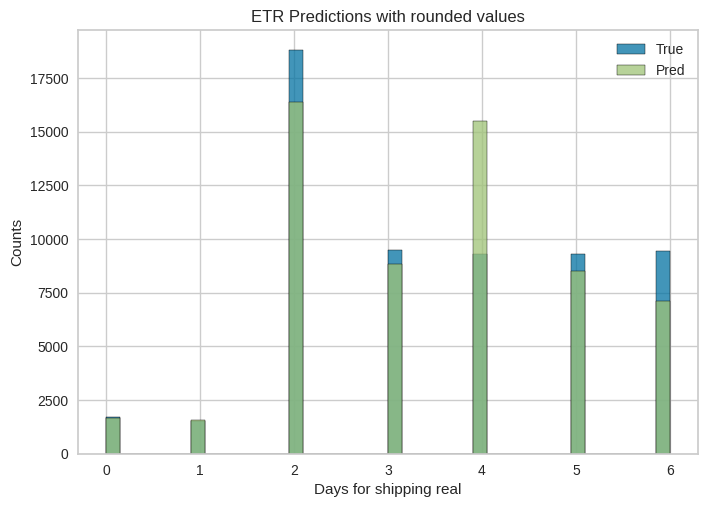

In [ ]:
rounded_etr = [np.round(x) for x in y_pred_etr]
#we can plot the results
import seaborn as sns
ax1 = sns.histplot(y_test, label = 'True')
sns.histplot(rounded_etr, label = 'Pred')

plt.legend()
plt.xlabel('Days for shipping real')
plt.ylabel('Counts')
plt.title('ETR Predictions with rounded values')

### DAYS OF DELAY DELIVERY

At the beggining we also tried to investigate the days of delay. However, the results were not optimal therefore we discarded the idea. The code is just displayed in order to show all the work done

In [ ]:
df = pd.read_csv(r"C:\Users\nickr\Downloads\df_final_encoded").drop('Unnamed: 0', axis=1)
df['days_of_delay'] = df['Days_for_shipping_real'] - df['Days_for_shipment_scheduled']

#function to clean all data + drop specific columns to avoid data leakage
df= df[(df.days_of_delay >= 0)&(df['Delivery_Status_Shipping canceled'] != 1)]
df = df.drop(['Days_for_shipment_scheduled', 'Delivery_Status_Advance shipping', 'Delivery_Status_Late delivery', 'Delivery_Status_Shipping canceled','Delivery_Status_Shipping on time', 'Late_delivery_risk', 'days_of_delay'], axis=1)

X = df[[i for i in df.columns if i != 'Days_for_shipping_real']].values
y = df['Days_for_shipping_real'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33)

In [ ]:
et = ExtraTreesRegressor()

# define the hyperparameter search space
param_dist = {'n_estimators': sp_randint(300, 900),
              'max_depth': [None] + list(range(5, 25)),
              'min_samples_split': sp_randint(2, 10),
              'min_samples_leaf': sp_randint(1, 4)
              }

# perform random search with cross-validation to find the best combination of hyperparameters
et_random = RandomizedSearchCV(estimator=et, param_distributions=param_dist,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 5, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
et_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_
rf_random.cv_results_

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)_    mape = 100 * np.mean(errors / y_test)
    r2 = r2_score(y_test, predictions)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

In [ ]:
average_days_of_delay = (df['Days for shipping (real)'] - df['Days for shipment (scheduled)']).mean()
print(f'The average days of delay is {average_days_of_delay}')
print(f'The rounded average days of delay is {round(average_days_of_delay)}')

## REGRESSION ON THE GROUPED DATASET

This section deals with the regression applied to the grouped dataset

### Creating grouped dataset

In [ ]:
agg_functions = {
    'Type': 'first',
    'Order Status': 'first',
    'Order City': 'first',
    'Customer City':'first',
    'Order State': 'first',
    'Customer State':'first',
    'Delivery Status': 'first',
    'Shipping Mode':'first',
    'Days for shipping (real)': 'first',
    'order date (DateOrders)': 'first',
    'Benefit per order': ['sum', 'median'],
    'Order Item Discount Rate': 'median',
    'Customer Segment': 'first',
    'Customer Id': 'first',
    'Latitude': 'first',
    'Longitude': 'first',
    #'Category Id': lambda x: ','.join(x.unique()),
    'Category Name': lambda x: ','.join(x.unique()),
    # Add the rest of the categorical columns with the lambda function
    'Order Item Total': ['sum','median'],
    'Order Item Quantity': ['sum']
    # Add any additional numerical columns with the appropriate aggregation functions
}
# Group by 'Order Id' and apply the aggregation functions
grouped_df = df.groupby('Order Id').agg(agg_functions).reset_index()

# Flatten the MultiIndex columns
grouped_df.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in grouped_df.columns]

### Preprocessing the grouped dataset

In [ ]:
grouped_df['order date (DateOrders)_first'] = pd.to_datetime(grouped_df['order date (DateOrders)_first'])
# Assuming you have a DataFrame named 'grouped_data' with a column 'Category Name' containing comma-separated values
# Convert the comma-separated strings to lists
grouped_df['Category Name_<lambda>'] = grouped_df['Category Name_<lambda>'].apply(lambda x: x.split(','))

mlb = MultiLabelBinarizer()

# Fit and transform the 'Category Name' column
category_name_encoded = mlb.fit_transform(grouped_df['Category Name_<lambda>'])

# Create a new DataFrame with binary features for each unique item in 'Category Name'
category_name_df = pd.DataFrame(category_name_encoded, columns=mlb.classes_)

# Combine the new binary features with the original DataFrame
grouped_df = pd.concat([grouped_df.drop(columns=['Category Name_<lambda>']), category_name_df], axis=1)

grouped_df['order date (DateOrders)_first'] = pd.to_datetime(grouped_df['order date (DateOrders)_first'])
grouped_df['order date (DateOrders)_first'] = pd.to_datetime(grouped_df['order date (DateOrders)_first'], unit='ms')
grouped_df['Order_Month'] = grouped_df['order date (DateOrders)_first'].dt.month
grouped_df['Order_Day'] =grouped_df['order date (DateOrders)_first'].dt.day
grouped_df['Order_Weekday'] = grouped_df['order date (DateOrders)_first'].dt.dayofweek

grouped_df = vaex.from_pandas(df=grouped_df, copy_index=False)
grouped_df = vaex.ml.CycleTransformer(features=['Order_Month'], n=12).fit_transform(grouped_df)
grouped_df = vaex.ml.CycleTransformer(features=['Order_Day'], n=31).fit_transform(grouped_df)
grouped_df = vaex.ml.CycleTransformer(features=['Order_Weekday'], n=7).fit_transform(grouped_df)
grouped_df = grouped_df.to_pandas_df()

class PreprocessDataFrame_regression:
    def __init__(self, df):
        self.df = df

    
    def drop_canceled(self):
        self.df = self.df[self.df['Order Status_first'] != 'CANCELED']
        return self.df
  
  #def cumulative_orders_customer(self):
     # self.df['Customer_Id'] = self.df['Customer_Id'].astype('object')
      #self.df['total_number_of_transactions_so_far'] = self.df.groupby('Customer_Id').cumcount() + 1

    def process_datetetimes(self):
        self.df.order_date_DateOrders = pd.to_datetime(self.df.order_date_DateOrders)
        (self.df.order_date_DateOrders.astype(np.int64) / int(1e6)).astype('int64')
        return self.df

    def augment_with_network_features(self):
        self.df['Source'] = ('LA' + self.df['Latitude_first'].astype('str') + '-' + 'LO' + self.df['Longitude_first'].astype('str'))
        G = nx.from_pandas_edgelist(self.df, source='Source', target='Order City_first')
        self.df['Source_Centrality'] = self.df.Source.map(dict(G.degree))
        return self.df

#grouped_df = PreprocessDataFrame_regression(grouped_df).add_target_variable()
grouped_df = PreprocessDataFrame_regression(grouped_df).drop_canceled()
grouped_df = PreprocessDataFrame_regression(grouped_df).augment_with_network_features()

    
X = grouped_df[[i for i in grouped_df.columns if i != 'Days for shipping (real)_first']]
X = grouped_df.drop(['Order_Month','Order_Day','Order_Weekday', 'order date (DateOrders)_first', 'InvoiceMonth',
                    'CohortMonth', 'Cohortdays', 'Order Status_first', 'Order Id_', 'Customer Id_first', 'Delivery Status_first', 'Days for shipping (real)_first'],axis=1)
y = grouped_df['Days for shipping (real)_first']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X_train = vaex.from_pandas(df=X_train, copy_index=False)
X_test = vaex.from_pandas(df=X_test, copy_index=False)
ohe = vaex.ml.OneHotEncoder(features=["Type_first", 
                                      "Customer Segment_first",'Shipping Mode_first'])
X_train = ohe.fit_transform(df=X_train)
X_test = ohe.transform(X_test)

mhe = vaex.ml.MultiHotEncoder(features=["Order City_first", "Customer City_first", 'Order State_first', 'Customer State_first'])
X_train = mhe.fit_transform(df=X_train)
X_test = mhe.transform(X_test)

X_train = X_train.to_pandas_df()
X_test = X_test.to_pandas_df()

X_train = X_train[X_train.dtypes[X_train.dtypes != 'object'].index.tolist()]
X_test = X_test[X_test.dtypes[X_test.dtypes != 'object'].index.tolist()]

### MODELS

#### POISSON REGRESSION

In [ ]:
from sklearn.linear_model import Ridge, PoissonRegressor
from sklearn.pipeline import make_pipeline

In [ ]:
numerical_features = X.select_dtypes(include='number').columns.tolist()

numeric_pipeline = Pipeline(steps = [
    ('minmax', MinMaxScaler())
    #('poly', PolynomialFeatures())
])

full_processor = ColumnTransformer([
     ('number', numeric_pipeline, numerical_features)])
    
pr = PoissonRegressor(alpha=0, fit_intercept=False, solver='lbfgs', max_iter=1000)

# set up pipeline
pr_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', pr)])

_=pr_pipeline.fit(X_train, y_train)
y_pred_poisson = pr_pipeline.predict(X_test)

In [ ]:
print('MAE:', mean_absolute_error(y_test, y_pred_poisson))
print('MSE: ', mean_squared_error(y_test, y_pred_poisson))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred_poisson))))
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_poisson))
print('R2: ', r2_score(y_test, y_pred_poisson))

MAE: 1.4291554266666175
MSE:  2.6659287673556356
RMSE: 2
MAPE:  438907590208708.8
R2:  -0.00677264266291111


#### XGBOOST REGRESSION

###### Bayesian Optimizer with poisson-nloglik

In [ ]:
#define the object function for the bayesian optimizer
def xgb_cv(max_depth, n_estimators, learning_rate, subsample, colsample_bytree):
    params = {
        'objective': 'count:poisson',
        'eval_metric': 'poisson-nloglik',
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree
    }
    
    xgb_r = xgb.XGBRegressor(**params)
    
    cv_result = cross_val_score(xgb_r, X_train, y_train, cv=3, scoring='neg_mean_absolute_error')
    
    return cv_result.mean()

#class_weights = len(y_train) / (2 * np.bincount(y_train))

#define the space for the bayesian optimizer
pbounds = {
    'max_depth': (3, 9),
    'n_estimators': (100, 1000),
    'learning_rate': (0.01, 0.5),
    'subsample': (0.1, 1),
    'colsample_bytree': (0.1, 1)
}

xgb_bo = BayesianOptimization(f=xgb_cv, pbounds=pbounds, verbose=2, random_state=42)
xgb_bo.maximize()

best_params = xgb_bo.max['params']

params = {
    'objective': 'count:poisson',
    'eval_metric': 'poisson-nloglik',
    'max_depth': int(best_params['max_depth']),
    'n_estimators': int(best_params['n_estimators']),
    'learning_rate': best_params['learning_rate'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree']
}

Parameter optimization: {'objective': 'count:poisson', 'eval_metric': 'poisson-nloglik', 'max_depth': 3, 'n_estimators': 432, 'learning_rate': 0.05062234345552188, 'subsample': 0.827911035387527, 'colsample_bytree': 0.23630708492374475}


In [ ]:
xgb_re = xgb.XGBRegressor( objective = 'count:poisson', 
                          eval_metric = 'poisson-nloglik', 
                          max_depth= 3, n_estimators = 432, 
                          learning_rate = 0.05062234345552188, 
                          subsample = 0.827911035387527,
                          colsample_bytree= 0.23630708492374475)
xgb_re.fit(X_train, y_train)

y_pred_bopt = xgb_re.predict(X_test)

In [ ]:
print('MAE:', mean_absolute_error(y_test, y_pred_bopt))
print('MSE: ', mean_squared_error(y_test, y_pred_bopt))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred_bopt))))
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_bopt))
print('R2: ', r2_score(y_test, y_pred_bopt))

MAE: 0.9867081451454166
MSE:  1.6007546405397115
RMSE: 1
MAPE:  72410649828685.42
R2:  0.39044488458571147


In [ ]:
#we can round the values, since our aim is to predict the days in delay, that are dicrete values
rounded = [np.round(x) for x in y_pred_bopt]
print('MAE:', mean_absolute_error(y_test, rounded))
print('MSE: ', mean_squared_error(y_test, rounded))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, rounded))))
print('R2: ', r2_score(y_test, rounded))

MAE: 0.9768919427710844
MSE:  1.6129047439759037
RMSE: 1
R2:  0.38581821819051265


Text(0.5, 1.0, 'ETR Predictions with rounded values')

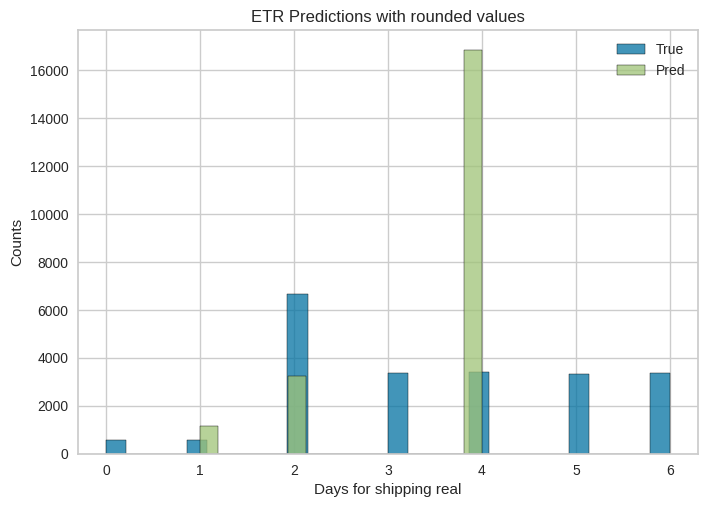

In [ ]:
#we can plot the results
import seaborn as sns
ax1 = sns.histplot(y_test, label = 'True')
sns.histplot(rounded, label = 'Pred')

plt.legend()
plt.xlabel('Days for shipping real')
plt.ylabel('Counts')
plt.title('ETR Predictions with rounded values')

The poisson-nloglik will predict just non-negative values, therefore the value 0 will never predicted

###### Bayesian Optimizer with count-poisson

In [ ]:
#define the object function for the bayesian optimizer
def xgb_cv(max_depth, n_estimators, learning_rate, subsample, colsample_bytree):
    params = {
        'objective': 'count:poisson',
        'eval_metric': 'rmse',
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree
    }
    
    xgb_r = xgb.XGBRegressor(**params)
    
    cv_result = cross_val_score(xgb_r, X_train, y_train, cv=3, scoring='r2')
    
    return cv_result.mean()

#class_weights = len(y_train) / (2 * np.bincount(y_train))

#define the space for the bayesian optimizer
pbounds = {
    'max_depth': (3, 9),
    'n_estimators': (100, 1000),
    'learning_rate': (0.01, 0.5),
    'subsample': (0.1, 1),
    'colsample_bytree': (0.1, 1)
}

xgb_bo = BayesianOptimization(f=xgb_cv, pbounds=pbounds, verbose=2, random_state=42)
xgb_bo.maximize()

best_params = xgb_bo.max['params']

params = {
    'objective': 'count:poisson',
    'eval_metric': 'rmse',
    'max_depth': int(best_params['max_depth']),
    'n_estimators': int(best_params['n_estimators']),
    'learning_rate': best_params['learning_rate'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree']
}

print(params)

In [ ]:
xgb_re = xgb.XGBRegressor(objective= 'count:poisson', eval_metric= 'rmse', max_depth= 4, n_estimators= 429, 
                           learning_rate= 0.04703932578677511, subsample= 0.5667312556276768, colsample_bytree= 0.6927866702708748)
xgb_re.fit(X_train, y_train)
y_pred_bopt = xgb_re.predict(X_test)

In [ ]:
print('MAE:', mean_absolute_error(y_test, y_pred_bopt))
print('MSE: ', mean_squared_error(y_test, y_pred_bopt))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred_bopt))))
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_bopt))
print('R2: ', r2_score(y_test, y_pred_bopt))

MAE: 0.9875512390512502
MSE:  1.6006915577456202
RMSE: 1
MAPE:  58353788270468.94
R2:  0.39046890603088436


In [ ]:
#we can round the values, since our aim is to predict the days in delay, that are dicrete values
rounded = [np.round(x) for x in y_pred_bopt]
print('MAE:', mean_absolute_error(y_test, rounded))
print('MSE: ', mean_squared_error(y_test, rounded))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, rounded))))
print('R2: ', r2_score(y_test, rounded))

MAE: 0.9746799698795181
MSE:  1.6106927710843373
RMSE: 1
R2:  0.38666052053783384


Text(0.5, 1.0, 'ETR Predictions with rounded values')

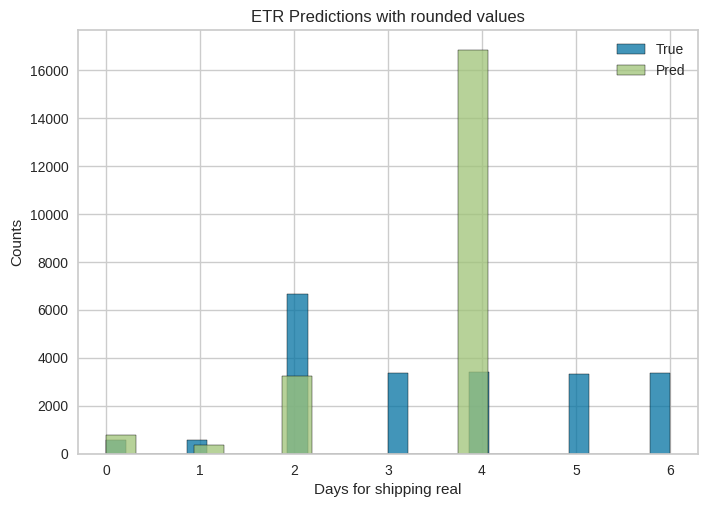

In [ ]:
#we can plot the results
import seaborn as sns
ax1 = sns.histplot(y_test, label = 'True')
sns.histplot(rounded, label = 'Pred')

plt.legend()
plt.xlabel('Days for shipping real')
plt.ylabel('Counts')
plt.title('ETR Predictions with rounded values')

#### RANDOM FOREST REGRESSOR

In [ ]:
#without any tuning
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)

print('MAE:', mean_absolute_error(y_test, y_rf))
print('MSE: ', mean_squared_error(y_test, y_rf))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_rf))))
print('MAPE: ', mean_absolute_percentage_error(y_test, y_rf))
print('R2: ', r2_score(y_test, y_rf))

MAE: 0.9979240399096385
MSE:  1.6193518778237952
RMSE: 1
MAPE:  56470917202575.67
R2:  0.3833631989656938


In [ ]:
#we can round the values, since our aim is to predict the days in delay, that are dicrete values
rounded = [np.round(x) for x in y_rf]
print('MAE:', mean_absolute_error(y_test, rounded))
print('MSE: ', mean_squared_error(y_test, rounded))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, rounded))))
print('R2: ', r2_score(y_test, rounded))

MAE: 0.9746799698795181
MSE:  1.6106927710843373
RMSE: 1
R2:  0.38666052053783384


Text(0.5, 1.0, 'ETR Predictions with rounded values')

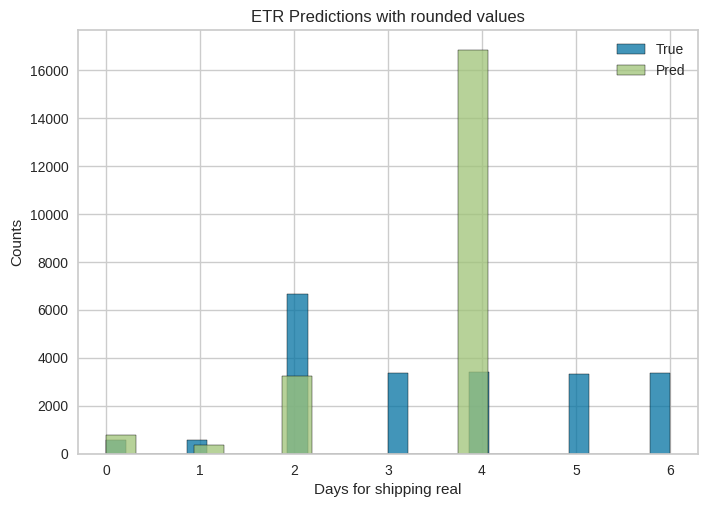

In [ ]:
#we can plot the results
import seaborn as sns
ax1 = sns.histplot(y_test, label = 'True')
sns.histplot(rounded, label = 'Pred')

plt.legend()
plt.xlabel('Days for shipping real')
plt.ylabel('Counts')
plt.title('Random Forest Predictions with rounded values')

#### Stacking: an Ensemble approach for days prediction

In [ ]:
# Define the base models
base_models = [
    LinearRegression(),
    Ridge(),
    DecisionTreeRegressor(),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42)
]

# Define the meta-model
meta_model = LinearRegression()

# Generate the predictions for the base models using cross-validation
X_blend = np.zeros((X_train.shape[0], len(base_models)))
for i, model in enumerate(base_models):
    y_pred = cross_val_predict(model, X_train, y_train, cv=5)
    X_blend[:, i] = y_pred

# Train the meta-model on the blended predictions
meta_model.fit(X_blend, y_train)

# Fit the base models to the entire training set and generate test set predictions
X_test_blend = np.zeros((X_test.shape[0], len(base_models)))
for i, model in enumerate(base_models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    X_test_blend[:, i] = y_pred

# Generate the final predictions using the meta-model
y_pred_blend = meta_model.predict(X_test_blend)

# Evaluate the performance
r2_blend = r2_score(y_test, y_pred_blend)
print("R2 score for blended model:", r2_blend)

R2 score for blended model: 0.39067319456733374


## Regression with Stratfied ORDER ID - GroupShuffleSplit (Original dataset)

This is applied in the original dataset but with a different method for the training and test split. In this section we are going to use the GroupShuffleSplit which is used to make sure that all the items of an order remain together when splitting. 

In [ ]:
class PreprocessDataFrame:
    def __init__(self, df):
        self.df = df


    def parse_column_names(self):
        self.df.columns = [i.replace(' ','_').replace('(','').replace(')','') for i in self.df.columns]
        return self.df

    def drop_unuseful_columns(self):
        to_drop = ['Customer_City', 'Customer_Country', 'Customer_Email', 'Customer_Fname', 'Customer_Id',
                   'Customer_Lname', 'Customer_Password', 'Customer_Street', 'Customer_Zipcode',
                   'Product_Description', 'Product_Image', 'Product_Status', 'Order_Zipcode', 'Order_Item_Id',
                   'Order_Country', 'Order_Customer_Id', 'Order_Country', 'Order_Region', 'Order_State',
                   'Market', 'Customer_State', 'Order_Item_Cardprod_Id', 'Product_Card_Id',
                   'Order_Profit_Per_Order','Department_Id','Product_Price','Category_Id']

        self.df['Category_Department_Name'] = (self.df['Category_Name'] + '_' + self.df['Department_Name']) \
            .str.replace(' ', '_')

        self.df = self.df.drop(to_drop + ['Category_Name','Department_Name'], axis=1)
        return self.df

    def process_datetetimes(self):
        self.df.shipping_date_DateOrders = pd.to_datetime(self.df.shipping_date_DateOrders)
        (self.df.shipping_date_DateOrders.astype(np.int64) / int(1e6)).astype('int64')

        self.df.order_date_DateOrders = pd.to_datetime(self.df.order_date_DateOrders)
        (self.df.order_date_DateOrders.astype(np.int64) / int(1e6)).astype('int64')
        return self.df

    def augment_with_network_features(self):
        self.df['Source'] = ('LA' + self.df['Latitude'].astype('str') + '-' + 'LO' + self.df['Longitude'].astype('str'))
        G = nx.from_pandas_edgelist(self.df, source='Source', target='Order_City')
        self.df['Source_Centrality'] = self.df.Source.map(dict(G.degree))
        return self.df
    
    
    
#create to encode the categorical data, deal with dates, and drop unnecessary columns
#In particular, the type of payment, order status, and delivery status were drop due to the presence of a really high correlation between the 'canceled' delivery and the fraudolent orders
#All the suspcted frauds were canceled. However, it makes no sense knowing in advance that some orders are cancelled, therefore, they can be dropped. 
from sklearn.model_selection import GroupShuffleSplit
class ClassificationDataframeProcessor:

    def __init__(self):
        self.columns_for_ml = ['Benefit_per_order',
                               'Order_Id',
                               'Customer_Segment','Latitude','Longitude','Order_City',
                               'Order_Item_Discount','Order_Item_Discount_Rate', 'Type',
                               'Order_Item_Product_Price','Order_Item_Profit_Ratio','Order_Item_Quantity',
                               'Sales', 'Days_for_shipping_real',
                               'Shipping_Mode','Category_Department_Name','Source_Centrality', 'Order_Month',
                               'Order_Day','Order_Weekday']

    def process_df_for_classification(self, df):
        df['shipping_date_DateOrders'] = pd.to_datetime(df['shipping_date_DateOrders'], unit='ms')
        df['order_date_DateOrders'] = pd.to_datetime(df['order_date_DateOrders'], unit='ms')

        df['Order_Month'] = df.order_date_DateOrders.dt.month
        df['Order_Day'] = df.order_date_DateOrders.dt.day
        df['Order_Weekday'] = df.order_date_DateOrders.dt.dayofweek

        ml = df[self.columns_for_ml]
        return ml

    def cycletransform_month_day_weekday(self,df):
        """
        
        """
        ml = vaex.from_pandas(df=df, copy_index=False)
        ml = vaex.ml.CycleTransformer(features=['Order_Month'], n=12).fit_transform(ml)
        ml = vaex.ml.CycleTransformer(features=['Order_Day'], n=31).fit_transform(ml)
        ml = vaex.ml.CycleTransformer(features=['Order_Weekday'], n=7).fit_transform(ml)
        ml = ml.to_pandas_df()
        return ml

    def return_processed_and_split_X_y(self, df):
        X = df[[i for i in df.columns if i != 'Days_for_shipping_real']]
        X = X.drop(['Order_Month', 'Order_Day', 'Order_Weekday'], axis=1)
        y = df['Days_for_shipping_real']
        
        #Introducing the GroupShuffleSplit
        groups = df['Order_Id'] 
        splitter = GroupShuffleSplit(n_splits=2, test_size=0.33)
        train_idx, test_idx = next(splitter.split(X, y, groups))

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        X_train = X_train.drop('Order_Id', axis=1)
        X_test = X_test.drop('Order_Id', axis=1)

        return X_train, X_test, y_train, y_test

    @staticmethod
    def encode_Xtrain_Xtest(X_train,X_test):

        X_train = vaex.from_pandas(df=X_train, copy_index=False)
        X_test = vaex.from_pandas(df=X_test, copy_index=False)
        ohe = vaex.ml.OneHotEncoder(features=["Type", "Customer_Segment",'Shipping_Mode'])
        X_train = ohe.fit_transform(df=X_train)
        X_test = ohe.transform(X_test)

        mhe = vaex.ml.MultiHotEncoder(features=["Order_City", "Category_Department_Name"])
        X_train = mhe.fit_transform(df=X_train)
        X_test = mhe.transform(X_test)

        X_train = X_train.to_pandas_df()
        X_test = X_test.to_pandas_df()

        X_train = X_train[X_train.dtypes[X_train.dtypes != 'object'].index.tolist()]
        X_test = X_test[X_test.dtypes[X_test.dtypes != 'object'].index.tolist()]

        return X_train, X_test

#read the original data
df_original = pd.read_csv("SupplyChainDataset.csv", encoding='latin-1')

#apply the PreprocessDataFrame class and its related functions. 

preprocessor = PreprocessDataFrame(df_original).parse_column_names()
preprocessor = PreprocessDataFrame(preprocessor).drop_unuseful_columns()
preprocessor = PreprocessDataFrame(preprocessor).process_datetetimes()
preprocessor = PreprocessDataFrame(preprocessor).augment_with_network_features()  #This class add the 'Source_Centrality' measure, which rely on networkz built-in function to compute the 
#importance of the source (the Stores, as identified by their lat and long features') on the targets (the order cities). 
#apply the class for the dataframe processor for the models
cdp = ClassificationDataframeProcessor()
df_class = cdp.process_df_for_classification(preprocessor)
df_class = cdp.cycletransform_month_day_weekday(df_class)
X_train, X_test, y_train, y_test = cdp.return_processed_and_split_X_y(df_class)
X_train, X_test = cdp.encode_Xtrain_Xtest(X_train, X_test)

### MODELS

#### EXTRA TREE REGRESSOR WITH GROUPED SHUFFLE SPLIT

In [ ]:
#applying the extratree regressor 
etr = ExtraTreesRegressor()
_=etr.fit(X_train, y_train)
y_pred_etr = etr.predict(X_test)

In [ ]:
print('MAE:', mean_absolute_error(y_test, y_pred_etr))
print('MSE: ', mean_squared_error(y_test, y_pred_etr))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred_etr))))
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_etr))
print('R2: ', r2_score(y_test, y_pred_etr))

MAE: 1.0307712237962248
MSE:  1.7572308523166997
RMSE: 1
MAPE:  48325916792908.93
R2:  0.3233800576423709


In [ ]:
rounded_etr_shuffle = [np.round(x) for x in y_pred_etr]

In [ ]:
print('MAE:', mean_absolute_error(y_test, rounded_etr_shuffle))
print('MSE: ', mean_squared_error(y_test, rounded_etr_shuffle))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, rounded_etr_shuffle))))
print('MAPE: ', mean_absolute_percentage_error(y_test, rounded_etr_shuffle))
print('R2: ', r2_score(y_test, rounded_etr_shuffle))

MAE: 1.0085298966990814
MSE:  1.7926747198761734
RMSE: 1
MAPE:  34854063538316.344
R2:  0.30973243269121253


Text(0.5, 1.0, 'ETR Predictions with rounded values')

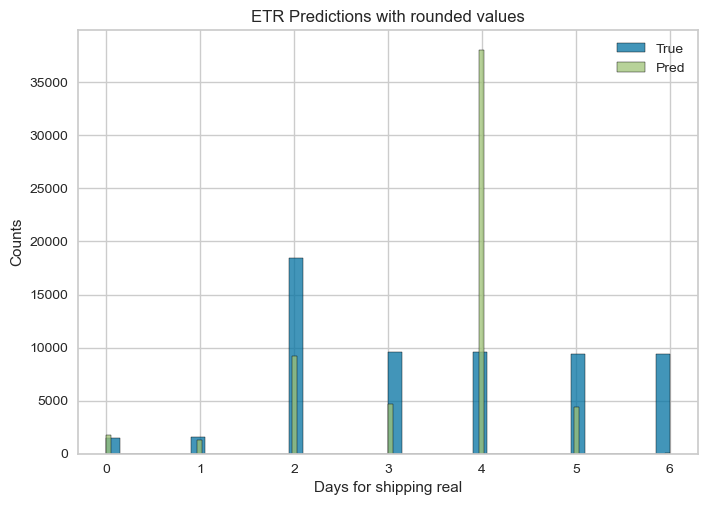

In [ ]:
import seaborn as sns
ax1 = sns.histplot(y_test, label = 'True')
sns.histplot(rounded_etr_shuffle, label = 'Pred')

plt.legend()
plt.xlabel('Days for shipping real')
plt.ylabel('Counts')
plt.title('ETR Predictions with rounded values')

This new approach has not led to any improvments in the models 

### Tuning of ETR

In [ ]:
#

#### XGBOOST REGRESSOR WITH GROUPED SHUFFLE SPLIT

In [ ]:
xgb_re = xgb.XGBRegressor(objective= 'count:poisson', eval_metric= 'rmse')
xgb_re.fit(X_train, y_train)
y_pred_xgb = xgb_re.predict(X_test)

In [ ]:
print('MAE:', mean_absolute_error(y_test, y_pred_xgb))
print('MSE: ', mean_squared_error(y_test, y_pred_xgb))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred_xgb))))
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_xgb))
print('R2: ', r2_score(y_test, y_pred_xgb))

MAE: 1.0099413998971871
MSE:  1.6404495957320018
RMSE: 1
MAPE:  62975328729919.41
R2:  0.3811208950621212


Text(0.5, 1.0, 'XGB Predictions with rounded values')

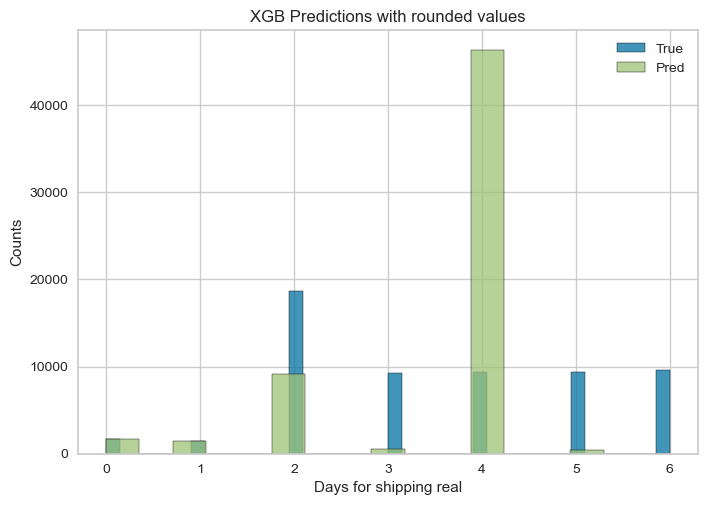

In [ ]:
rounded_xgb_shuffle = [np.round(x) for x in y_pred_xgb]

import seaborn as sns
ax1 = sns.histplot(y_test, label = 'True')
sns.histplot(rounded_xgb_shuffle, label = 'Pred')

plt.legend()
plt.xlabel('Days for shipping real')
plt.ylabel('Counts')
plt.title('XGB Predictions with rounded values')

#### TUNING XGBREGRESSOR

Tuning with the poisson-nloglik as eval-metric

In [ ]:
#define the object function for the bayesian optimizer
def xgb_cv(max_depth, n_estimators, learning_rate, subsample, colsample_bytree):
    params = {
        'objective': 'count:poisson',
        'eval_metric': 'poisson-nloglik',
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree
    }
    
    xgb_r = xgb.XGBRegressor(**params)
    
    cv_result = cross_val_score(xgb_r, X_train, y_train, cv=3, scoring='r2')
    
    return cv_result.mean()

#class_weights = len(y_train) / (2 * np.bincount(y_train))

#define the space for the bayesian optimizer
pbounds = {
    'max_depth': (3, 9),
    'n_estimators': (100, 1000),
    'learning_rate': (0.01, 0.5),
    'subsample': (0.1, 1),
    'colsample_bytree': (0.1, 1)
}

xgb_bo = BayesianOptimization(f=xgb_cv, pbounds=pbounds, verbose=2, random_state=42)
xgb_bo.maximize()

best_params = xgb_bo.max['params']

params = {
    'objective': 'count:poisson',
    'eval_metric': 'rmse',
    'max_depth': int(best_params['max_depth']),
    'n_estimators': int(best_params['n_estimators']),
    'learning_rate': best_params['learning_rate'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree']
}

print(params)

In [ ]:
#This paramteres are take from th Bayesian Optimizer runned on the shuffled data
xgb_re_bopt = xgb.XGBRegressor(objective = 'count:poisson', 
                          eval_metric = 'poisson-nloglik', 
                          max_depth= 3, n_estimators = 432, 
                          learning_rate = 0.05062234345552188, 
                          subsample = 0.827911035387527,
                          colsample_bytree= 0.23630708492374475)
xgb_re_bopt.fit(X_train, y_train)
y_pred_bopt = xgb_re_bopt.predict(X_test)

In [ ]:
print('MAE:', mean_absolute_error(y_test, y_pred_bopt))
print('MSE: ', mean_squared_error(y_test, y_pred_bopt))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred_bopt))))
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_bopt))
print('R2: ', r2_score(y_test, y_pred_bopt))

MAE: 0.995158476608658
MSE:  1.619659729642251
RMSE: 1
MAPE:  91557629562417.34
R2:  0.38896411910928375


Text(0.5, 1.0, 'XGB Predictions with rounded values')

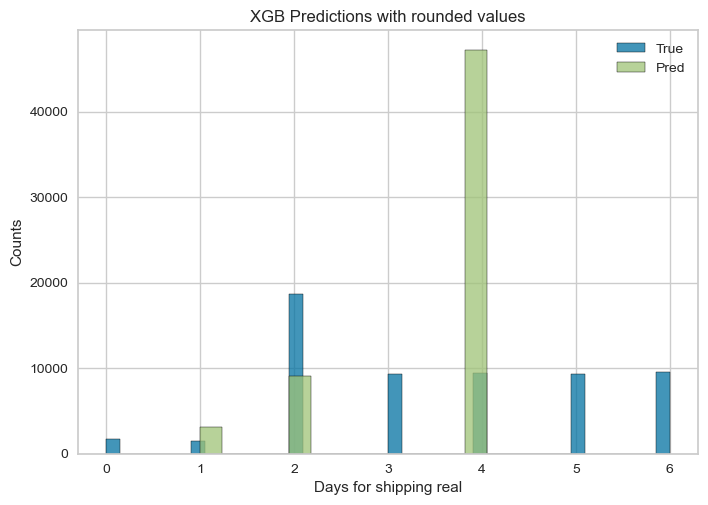

In [ ]:
rounded_xgb_shuffle = [np.round(x) for x in y_pred_bopt]

import seaborn as sns
ax1 = sns.histplot(y_test, label = 'True')
sns.histplot(rounded_xgb_shuffle, label = 'Pred')

plt.legend()
plt.xlabel('Days for shipping real')
plt.ylabel('Counts')
plt.title('XGB Predictions with rounded values')

Tuning with rmse as eval-metric

In [ ]:
#define the object function for the bayesian optimizer
def xgb_cv(max_depth, n_estimators, learning_rate, subsample, colsample_bytree):
    params = {
        'objective': 'count:poisson',
        'eval_metric': 'rmse',
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree
    }
    
    xgb_r = xgb.XGBRegressor(**params)
    
    cv_result = cross_val_score(xgb_r, X_train, y_train, cv=3, scoring='r2')
    
    return cv_result.mean()

#class_weights = len(y_train) / (2 * np.bincount(y_train))

#define the space for the bayesian optimizer
pbounds = {
    'max_depth': (3, 9),
    'n_estimators': (100, 1000),
    'learning_rate': (0.01, 0.5),
    'subsample': (0.1, 1),
    'colsample_bytree': (0.1, 1)
}

xgb_bo = BayesianOptimization(f=xgb_cv, pbounds=pbounds, verbose=2, random_state=42)
xgb_bo.maximize()

best_params = xgb_bo.max['params']

params = {
    'objective': 'count:poisson',
    'eval_metric': 'rmse',
    'max_depth': int(best_params['max_depth']),
    'n_estimators': int(best_params['n_estimators']),
    'learning_rate': best_params['learning_rate'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree']
}

print(params)

In [ ]:
params= {'objective': 'count:poisson', 'eval_metric': 'rmse', 'max_depth': 8, 'n_estimators': 642, 'learning_rate': 0.3630712868719002, 'subsample': 0.9497725803276883, 'colsample_bytree': 0.5654500440594056}

#This paramteres are take from th Bayesian Optimizer runned on the shuffled data
xgb_re_bopt = xgb.XGBRegressor(**params)
xgb_re_bopt.fit(X_train, y_train)
y_pred_bopt = xgb_re_bopt.predict(X_test)

In [ ]:
print('MAE:', mean_absolute_error(y_test, y_pred_bopt))
print('MSE: ', mean_squared_error(y_test, y_pred_bopt))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred_bopt))))
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_bopt))
print('R2: ', r2_score(y_test, y_pred_bopt))

In [ ]:
rounded_xgb_shuffle = [np.round(x) for x in y_pred_bopt]

import seaborn as sns
ax1 = sns.histplot(y_test, label = 'True')
sns.histplot(rounded_xgb_shuffle, label = 'Pred')

plt.legend()
plt.xlabel('Days for shipping real')
plt.ylabel('Counts')
plt.title('XGB Predictions with rounded values')

In [ ]:
explainer = shap.TreeExplainer(xgb_re_bopt)
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns, plot_type='bar')

## GROUPED DATA + STRATIFIED SHUFFLE SPLIT FOR DAYS FOR SHIPPING REAL

In [ ]:
pd.set_option('display.max_columns',None)

In [ ]:
df = pd.read_csv("SupplyChainDataset.csv")

agg_functions = {
    'Type': 'first',
    'Order Status': 'first',
    'Order City': 'first',
    'Customer City':'first',
    'Order State': 'first',
    'Customer State':'first',
    'Delivery Status': 'first',
    'Shipping Mode':'first',
    'Days for shipping (real)': 'first',
    'order date (DateOrders)': 'first',
    'Benefit per order': ['sum', 'median'],
    'Order Item Discount Rate': 'median',
    'Customer Segment': 'first',
    'Customer Id': 'first',
    'Latitude': 'first',
    'Longitude': 'first',
    'Category Name': lambda x: ','.join(x.unique()),
    # Add the rest of the categorical columns with the lambda function
    'Order Item Total': ['sum','median'],
    'Order Item Quantity': ['sum']
    # Add any additional numerical columns with the appropriate aggregation functions
}
# Group by 'Order Id' and apply the aggregation functions
grouped_df = df.groupby('Order Id').agg(agg_functions).reset_index()

# Flatten the MultiIndex columns
grouped_df.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in grouped_df.columns]

grouped_df['order date (DateOrders)_first'] = pd.to_datetime(grouped_df['order date (DateOrders)_first'])

# Assuming you have a DataFrame named 'grouped_data' with a column 'Category Name' containing comma-separated values
# Convert the comma-separated strings to lists
grouped_df['Category Name_<lambda>'] = grouped_df['Category Name_<lambda>'].apply(lambda x: x.split(','))

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the 'Category Name' column
category_name_encoded = mlb.fit_transform(grouped_df['Category Name_<lambda>'])

# Create a new DataFrame with binary features for each unique item in 'Category Name'
category_name_df = pd.DataFrame(category_name_encoded, columns=mlb.classes_)

# Combine the new binary features with the original DataFrame
grouped_df = pd.concat([grouped_df.drop(columns=['Category Name_<lambda>']), category_name_df], axis=1)

grouped_df['order date (DateOrders)_first'] = pd.to_datetime(grouped_df['order date (DateOrders)_first'])
grouped_df['order date (DateOrders)_first'] = pd.to_datetime(grouped_df['order date (DateOrders)_first'], unit='ms')
grouped_df['Order_Month'] = grouped_df['order date (DateOrders)_first'].dt.month
grouped_df['Order_Day'] =grouped_df['order date (DateOrders)_first'].dt.day
grouped_df['Order_Weekday'] = grouped_df['order date (DateOrders)_first'].dt.dayofweek

grouped_df = vaex.from_pandas(df=grouped_df, copy_index=False)
grouped_df = vaex.ml.CycleTransformer(features=['Order_Month'], n=12).fit_transform(grouped_df)
grouped_df = vaex.ml.CycleTransformer(features=['Order_Day'], n=31).fit_transform(grouped_df)
grouped_df = vaex.ml.CycleTransformer(features=['Order_Weekday'], n=7).fit_transform(grouped_df)
grouped_df = grouped_df.to_pandas_df()

class PreprocessDataFrame_regression:
    def __init__(self, df):
        self.df = df

    def drop_canceled(self):
        self.df = self.df[self.df['Order Status_first'] != 'CANCELED']
        return self.df

    def process_datetetimes(self):
        self.df.order_date_DateOrders = pd.to_datetime(self.df.order_date_DateOrders)
        (self.df.order_date_DateOrders.astype(np.int64) / int(1e6)).astype('int64')
        return self.df

    def augment_with_network_features(self):
        self.df['Source'] = ('LA' + self.df['Latitude_first'].astype('str') + '-' + 'LO' + self.df['Longitude_first'].astype('str'))
        G = nx.from_pandas_edgelist(self.df, source='Source', target='Order City_first')
        self.df['Source_Centrality'] = self.df.Source.map(dict(G.degree))
        return self.df

grouped_df = PreprocessDataFrame_regression(grouped_df).drop_canceled()
grouped_df = PreprocessDataFrame_regression(grouped_df).augment_with_network_features()
   
X = grouped_df[[i for i in grouped_df.columns if i != 'Days for shipping (real)_first']]
X = grouped_df.drop(['Order_Month','Order_Day','Order_Weekday', 'order date (DateOrders)_first',
                'Order Status_first', 'Order Id_', 'Customer Id_first', 'Delivery Status_first', 'Days for shipping (real)_first'],axis=1)

y = grouped_df['Days for shipping (real)_first']

In [ ]:
#using Stratified Shuffle Split
sss = StratifiedShuffleSplit(n_splits = 5, test_size = 0.33, random_state = 42)
group_label =  grouped_df['Days for shipping (real)_first']
type(sss.split(grouped_df, group_label))

for train_index, test_index in sss.split(grouped_df, group_label):
    #print("n_split", "TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
X_train = vaex.from_pandas(df=X_train, copy_index=False)
X_test = vaex.from_pandas(df=X_test, copy_index=False)
ohe = vaex.ml.OneHotEncoder(features=["Type_first", 
                                      "Customer Segment_first",'Shipping Mode_first'])
X_train = ohe.fit_transform(df=X_train)
X_test = ohe.transform(X_test)

mhe = vaex.ml.MultiHotEncoder(features=["Order City_first", "Customer City_first", 'Order State_first', 'Customer State_first'])
X_train = mhe.fit_transform(df=X_train)
X_test = mhe.transform(X_test)

X_train = X_train.to_pandas_df()
X_test = X_test.to_pandas_df()

X_train = X_train[X_train.dtypes[X_train.dtypes != 'object'].index.tolist()]
X_test = X_test[X_test.dtypes[X_test.dtypes != 'object'].index.tolist()]

CHECKING THAT THE BOTH THE TRAIN AND THE TEST HAVE THE SAME PERCENTAGES FOR EACH VALUE

In [ ]:
y_train.value_counts(normalize=True)

2    0.312516
6    0.159098
4    0.158866
3    0.158078
5    0.157243
0    0.028027
1    0.026172
Name: Days for shipping (real)_first, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

2    0.312500
6    0.159074
4    0.158886
3    0.158085
5    0.157238
0    0.028003
1    0.026214
Name: Days for shipping (real)_first, dtype: float64

### MODELS

#### EXTRA TREES REGRESSOR CON GROUPED ID + STRATIFIED DAYS FOR SHIPPING REAL

In [ ]:
#Without any tuning 
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor()
_=etr.fit(X_train, y_train)
y_pred_etr = etr.predict(X_test)

In [ ]:
print('MAE:', mean_absolute_error(y_test, y_pred_etr))
print('MSE: ', mean_squared_error(y_test, y_pred_etr))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred_etr))))
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_etr))
print('R2: ', r2_score(y_test, y_pred_etr))

MAE: 1.0169121799698797
MSE:  1.6965659779743976
RMSE: 1
MAPE:  57202158670686.94
R2:  0.3566872905172336


#### RANDOM FOREST REGRESSOR

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [ ]:
print('MAE:', mean_absolute_error(y_test, y_pred_rf))
print('MSE: ', mean_squared_error(y_test, y_pred_rf))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred_rf))))
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_rf))
print('R2: ', r2_score(y_test, y_pred_rf))

MAE: 0.9992916980421687
MSE:  1.6285492422816268
RMSE: 1
MAPE:  59847345198811.18
R2:  0.3824782300366809


In [ ]:
rounded_rf_stratified_days = [np.round(x) for x in y_pred_rf]

print('MAE:', mean_absolute_error(y_test, rounded_rf_stratified_days))
print('MSE: ', mean_squared_error(y_test, rounded_rf_stratified_days))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, rounded_rf_stratified_days))))
print('MAPE: ', mean_absolute_percentage_error(y_test, rounded_rf_stratified_days))
print('R2: ', r2_score(y_test, rounded_rf_stratified_days))

MAE: 0.97265625
MSE:  1.6105515813253013
RMSE: 1
MAPE:  46417936671411.195
R2:  0.38930267670393603


Text(0.5, 1.0, 'RF Predictions with rounded values')

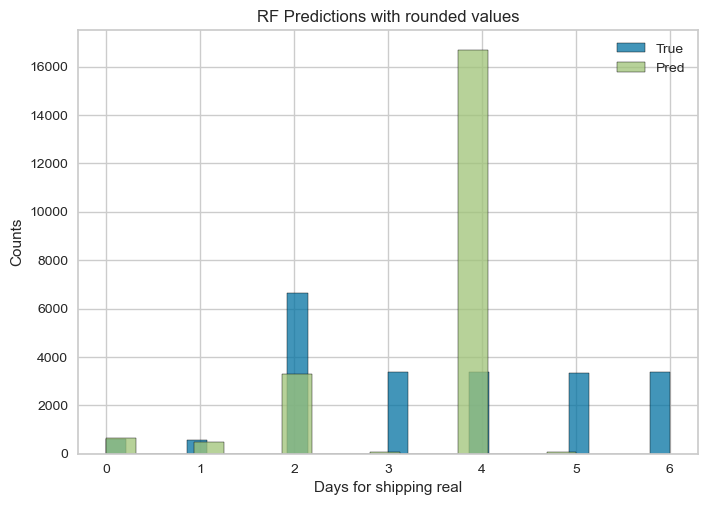

In [ ]:
import seaborn as sns
ax1 = sns.histplot(y_test, label = 'True')
sns.histplot(rounded_rf_stratified_days, label = 'Pred')

plt.legend()
plt.xlabel('Days for shipping real')
plt.ylabel('Counts')
plt.title('RF Predictions with rounded values')

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# define the hyperparameter search space
param_dist = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
              'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]
              }

# define the random forest regressor model
rf = RandomForestRegressor()

# perform random search with cross-validation to find the best combination of hyperparameters
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=50, scoring='neg_mean_absolute_error', 
                                   cv=3, verbose=2, random_state=42, n_jobs=-1)

# fit the random search model
random_search.fit(X_train, y_train)

# print the best hyperparameters and the best score
print('Best hyperparameters:', random_search.best_params_)
print('Best score:', -random_search.best_score_)

Best hyperparameters: {'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}
Best score: 0.9872096744732711

In [ ]:
rf = RandomForestRegressor(n_estimators= 2000, min_samples_split = 10, min_samples_leaf=2, max_depth=10)
rf.fit(X_train, y_train)
y_pred_rf = round_search.predict(X_test)
rounded_rf_stratified_days = [np.round(x) for x in y_pred_rf]

print('MAE:', mean_absolute_error(y_test, rounded_rf_stratified_days))
print('MSE: ', mean_squared_error(y_test, rounded_rf_stratified_days))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, rounded_rf_stratified_days))))
print('MAPE: ', mean_absolute_percentage_error(y_test, rounded_rf_stratified_days))
print('R2: ', r2_score(y_test, rounded_rf_stratified_days))

In [ ]:
import seaborn as sns
ax1 = sns.histplot(y_test, label = 'True')
sns.histplot(rounded_rf_stratified_days, label = 'Pred')

plt.legend()
plt.xlabel('Days for shipping real')
plt.ylabel('Counts')
plt.title('RF Predictions with rounded values')

#### XGBOOST REGRESSOR WITHOUT TUNING

In [ ]:
xgb_re = xgb.XGBRegressor(objective= 'count:poisson', eval_metric= 'rmse')
xgb_re.fit(X_train, y_train)
y_pred_xgb = xgb_re.predict(X_test)

In [ ]:
print('MAE:', mean_absolute_error(y_test, y_pred_xgb))
print('MSE: ', mean_squared_error(y_test, y_pred_xgb))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred_xgb))))
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_xgb))
print('R2: ', r2_score(y_test, y_pred_xgb))

MAE: 1.0050116926564903
MSE:  1.6275222288635418
RMSE: 1
MAPE:  60189156042579.59
R2:  0.382867658324906


Text(0.5, 1.0, 'XGB Predictions with rounded values (eval metric = rmse)')

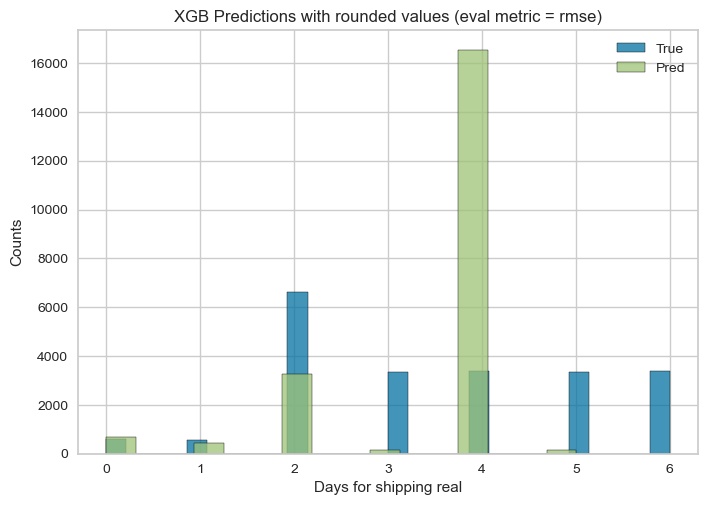

In [ ]:
rounded_xgb_stratified_days = [np.round(x) for x in y_pred_xgb]

import seaborn as sns
ax1 = sns.histplot(y_test, label = 'True')
sns.histplot(rounded_xgb_stratified_days, label = 'Pred')

plt.legend()
plt.xlabel('Days for shipping real')
plt.ylabel('Counts')
plt.title('XGB Predictions with rounded values (eval metric = rmse)')

#### XGBOOST REGRESSOR with TUNING poisson-nloglik

In [ ]:
#This paramteres are take from th Bayesian Optimizer runned on the shuffled data
xgb_re_bopt = xgb.XGBRegressor(objective = 'count:poisson', 
                          eval_metric = 'poisson-nloglik', 
                          max_depth= 3, n_estimators = 432, 
                          learning_rate = 0.05062234345552188, 
                          subsample = 0.827911035387527,
                          colsample_bytree= 0.23630708492374475)
xgb_re_bopt.fit(X_train, y_train)
y_pred_bopt = xgb_re_bopt.predict(X_test)

In [ ]:
print('MAE:', mean_absolute_error(y_test, y_pred_bopt))
print('MSE: ', mean_squared_error(y_test, y_pred_bopt))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred_bopt))))
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_bopt))
print('R2: ', r2_score(y_test, y_pred_bopt))

MAE: 0.9912314504225099
MSE:  1.6050143659532503
RMSE: 1
MAPE:  72201890873146.92
R2:  0.3914023068216147


In [ ]:
rounded_xgb_stratified_days = [np.round(x) for x in y_pred_bopt]

print('MAE:', mean_absolute_error(y_test, rounded_xgb_stratified_days))
print('MSE: ', mean_squared_error(y_test, rounded_xgb_stratified_days))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, rounded_xgb_stratified_days))))
print('MAPE: ', mean_absolute_percentage_error(y_test, rounded_xgb_stratified_days))
print('R2: ', r2_score(y_test, rounded_xgb_stratified_days))

MAE: 0.9791039156626506
MSE:  1.6150225903614457
RMSE: 1
MAPE:  124205072554551.78
R2:  0.387607336248861


Text(0.5, 1.0, 'XGB Predictions with rounded values (eval metric = nloglik)')

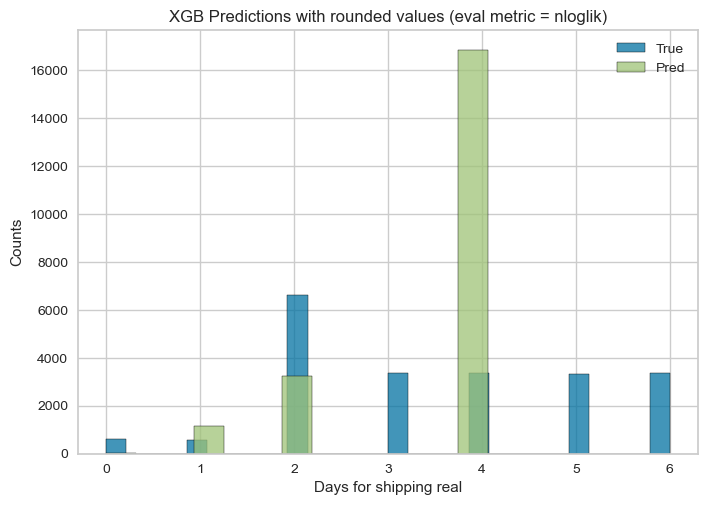

In [ ]:
import seaborn as sns
ax1 = sns.histplot(y_test, label = 'True')
sns.histplot(rounded_xgb_stratified_days, label = 'Pred')

plt.legend()
plt.xlabel('Days for shipping real')
plt.ylabel('Counts')
plt.title('XGB Predictions with rounded values (eval metric = nloglik)')

#### XGBOOST REGRESSOR with RMSE as eval-metric

In [ ]:
#define the object function for the bayesian optimizer
def xgb_cv(max_depth, n_estimators, learning_rate, subsample, colsample_bytree):
    params = {
        'objective': 'count:poisson',
        'eval_metric': 'rmse',
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree
    }
    
    xgb_r = xgb.XGBRegressor(**params)
    
    cv_result = cross_val_score(xgb_r, X_train, y_train, cv=3, scoring='r2')
    
    return cv_result.mean()

#class_weights = len(y_train) / (2 * np.bincount(y_train))

#define the space for the bayesian optimizer
pbounds = {
    'max_depth': (3, 9),
    'n_estimators': (100, 1000),
    'learning_rate': (0.01, 0.5),
    'subsample': (0.1, 1),
    'colsample_bytree': (0.1, 1)
}

xgb_bo = BayesianOptimization(f=xgb_cv, pbounds=pbounds, verbose=2, random_state=42)
xgb_bo.maximize()

best_params = xgb_bo.max['params']

params = {
    'objective': 'count:poisson',
    'eval_metric': 'rmse',
    'max_depth': int(best_params['max_depth']),
    'n_estimators': int(best_params['n_estimators']),
    'learning_rate': best_params['learning_rate'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree']
}

print(params)

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -0.1968   | 0.4371    | 0.4759    | 7.392     | 638.8     | 0.2404    |
| 2         | 0.3793    | 0.2404    | 0.03846   | 8.197     | 641.0     | 0.7373    |
| 3         | 0.145     | 0.1185    | 0.4853    | 7.995     | 291.1     | 0.2636    |
| 4         | 0.3516    | 0.2651    | 0.1591    | 6.149     | 488.8     | 0.3621    |
| 5         | 0.3844    | 0.6507    | 0.07835   | 4.753     | 429.7     | 0.5105    |
| 6         | 0.3875    | 0.6928    | 0.04704   | 4.763     | 429.6     | 0.5667    |
| 7         | 0.3442    | 0.85      | 0.08474   | 7.815     | 642.5     | 0.2594    |
| 8         | 0.3298    | 0.9029    | 0.1789    | 7.004     | 429.0     | 0.5283    |
| 9         | 0.3143    | 0.6789    | 0.2437    | 4.494     | 427.3     | 0.1167    |
| 10        | 0.3471    | 0.1493    | 0.4354    | 4.04

In [ ]:
params = {'objective': 'count:poisson', 'eval_metric': 'rmse', 'max_depth': 3, 'n_estimators': 488, 'learning_rate': 0.026341066972264876, 'subsample': 0.18729816033978203, 'colsample_bytree': 0.6206311390776479}
xgb_re = xgb.XGBRegressor(**params)
xgb_re.fit(X_train, y_train)
y_pred_bopt = xgb_re.predict(X_test)

In [ ]:
print('MAE:', mean_absolute_error(y_test, y_pred_bopt))
print('MSE: ', mean_squared_error(y_test, y_pred_bopt))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred_bopt))))
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_bopt))
print('R2: ', r2_score(y_test, y_pred_bopt))

MAE: 0.9890292462603896
MSE:  1.5978675602128196
RMSE: 1
MAPE:  65278827406200.6
R2:  0.39411226978486624


In [ ]:
rounded_xgb_stratified_tune = [np.round(x) for x in y_pred_bopt]

print('MAE:', mean_absolute_error(y_test, rounded_xgb_stratified_tune))
print('MSE: ', mean_squared_error(y_test, rounded_xgb_stratified_tune))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, rounded_xgb_stratified_tune))))
print('MAPE: ', mean_absolute_percentage_error(y_test, rounded_xgb_stratified_tune))
print('R2: ', r2_score(y_test, rounded_xgb_stratified_tune))

MAE: 0.9741152108433735
MSE:  1.6063629518072289
RMSE: 1
MAPE:  88384838319536.1
R2:  0.3908909430250065


Text(0.5, 1.0, 'XGB Predictions with rounded values (eval metric = nloglik)')

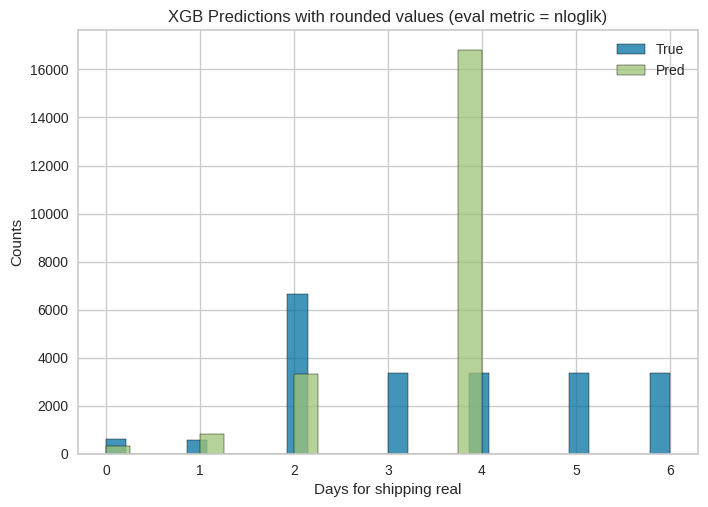

In [ ]:
import seaborn as sns
ax1 = sns.histplot(y_test, label = 'True')
sns.histplot(rounded_xgb_stratified_tune, label = 'Pred')

plt.legend()
plt.xlabel('Days for shipping real')
plt.ylabel('Counts')
plt.title('XGB Predictions with rounded values (eval metric = rmse)')

In [ ]:
explainer = shap.TreeExplainer(xgb_re)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


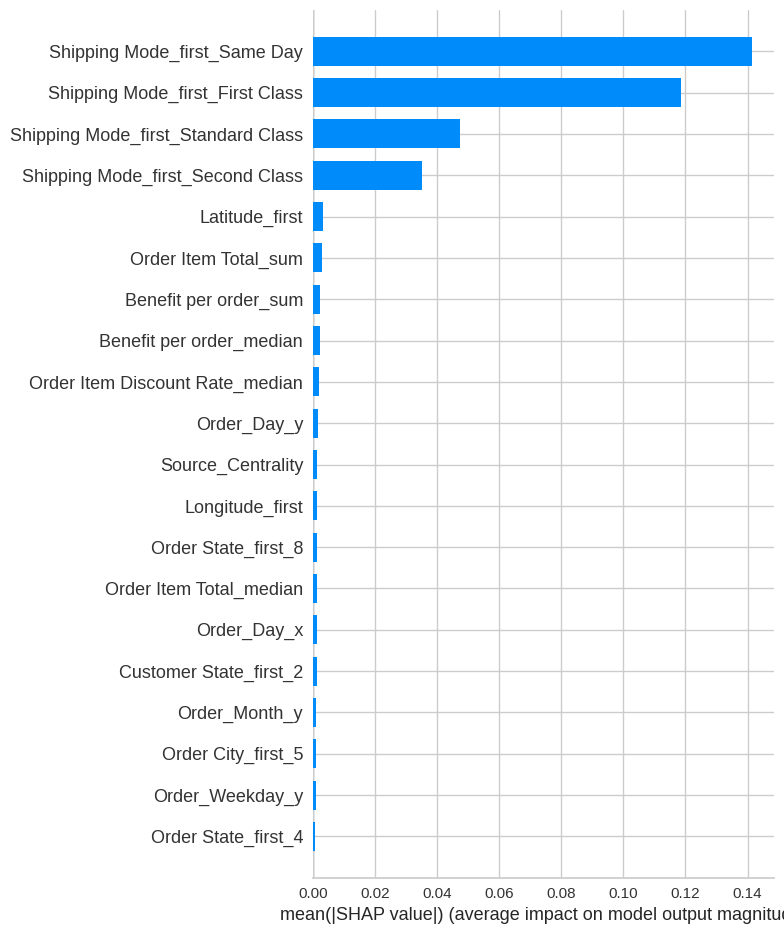

In [ ]:
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns, plot_type='bar', show=False)

plt.savefig('shap_plot1.png', bbox_inches='tight', dpi=300)


In [ ]:
X_train

,Benefit per order_sum,Benefit per order_median,Order Item Discount Rate_median,Latitude_first,Longitude_first,Order Item Total_sum,Order Item Total_median,Order Item Quantity_sum,Accessories,As Seen on TV!,Baby,Baseball & Softball,Basketball,Books,Boxing & MMA,CDs,Cameras,Camping & Hiking,Cardio Equipment,Children's Clothing,Cleats,Computers,Consumer Electronics,Crafts,DVDs,Electronics,Fishing,Fitness Accessories,Garden,Girls' Apparel,Golf Apparel,Golf Bags & Carts,Golf Balls,Golf Gloves,Golf Shoes,Health and Beauty,Hockey,Hunting & Shooting,Indoor/Outdoor Games,Kids' Golf Clubs,Lacrosse,Men's Clothing,Men's Footwear,Men's Golf Clubs,Music,Pet Supplies,Shop By Sport,Soccer,Sporting Goods,Strength Training,Tennis & Racquet,Toys,Trade-In,Video Games,Water Sports,Women's Apparel,Women's Clothing,Women's Golf Clubs,Order_Month_x,Order_Month_y,Order_Day_x,Order_Day_y,Order_Weekday_x,Order_Weekday_y,Source_Centrality,Type_first_CASH,Type_first_DEBIT,Type_first_PAYMENT,Type_first_TRANSFER,Customer Segment_first_Consumer,Customer Segment_first_Corporate,Customer Segment_first_Home Office,Shipping Mode_first_First Class,Shipping Mode_first_Same Day,Shipping Mode_first_Second Class,Shipping Mode_first_Standard Class,Order City_first_0,Order City_first_1,Order City_first_2,Order City_first_3,Order City_first_4,Order City_first_5,Order City_first_6,Order City_first_7,Order City_first_8,Order City_first_9,Order City_first_10,Order City_first_11,Customer City_first_0,Customer City_first_1,Customer City_first_2,Customer City_first_3,Customer City_first_4,Customer City_first_5,Customer City_first_6,Customer City_first_7,Customer City_first_8,Customer City_first_9,Customer City_first_10,Order State_first_0,Order State_first_1,Order State_first_2,Order State_first_3,Order State_first_4,Order State_first_5,Order State_first_6,Order State_first_7,Order State_first_8,Order State_first_9,Order State_first_10,Customer State_first_0,Customer State_first_1,Customer State_first_2,Customer State_first_3,Customer State_first_4,Customer State_first_5
0,177.529998,15.930000,0.090,18.227583,-66.043579,887.840027,175.990005,5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,8.660254e-01,-5.000000e-01,-0.250653,0.968077,1.000000,0.000000,7,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,1,1,1,0,1,1,0,1,1,1,1,0,0,1,0,1
1,143.319998,38.480000,0.090,42.375729,-83.413147,759.850006,181.990005,12,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-8.660254e-01,5.000000e-01,0.918958,-0.394356,0.623490,-0.781831,4,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,1,0,1,1,0,0,1,1,1,0,0,1,0,1,1,1
2,157.580000,34.460000,0.150,42.901985,-85.678223,622.400005,163.730000,11,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.000000e-01,8.660254e-01,-0.874347,0.485302,1.000000,0.000000,3,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,1,1,1,1,1,1,0,1,0,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,1,1,1
3,11.160000,5.580000,0.100,34.310200,-118.453079,220.500000,110.250000,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5.000000e-01,8.660254e-01,0.347305,-0.937752,-0.222521,-0.974928,10,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,1,0,0,1,1,1,1,0,1,1,1,1,0,0,1,0,0,1,1,1,0,1,0,0,0,0,1,1,0
4,-52.830002,-26.415001,0.060,34.052338,-118.241814,234.870003,117.435001,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.660254e-01,5.000000e-01,-0.440394,-0.897805,-0.222521,-0.974928,5,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,1,1,1,0,0,1,1,1,0,0,0,1,0,1,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

As we can see from the model, the only days that are predicted are 0,1,2 and 4. These are the values that can be found in "Days for shipment (scheduled)" column. 


### PREDICTING DAYS OF DELIVERY SCHEDULED

In this experiment, we tried to set as target variable y the column "Days of delivery (Scheduled)" in order to understand whether our model could only predict these values and not the actual days. We believe that in the dataset there are no information that could help us to predict the real days of delivery since a delay in a shipment could depend on many external factor not present in the dataset and not on the characteristic of the order itself. 

In [ ]:
df = pd.read_csv("SupplyChainDataset.csv")
agg_functions = {
    'Type': 'first',
    'Order Status': 'first',
    'Order City': 'first',
    'Customer City':'first',
    'Order State': 'first',
    'Customer State':'first',
    'Delivery Status': 'first',
    'Shipping Mode':'first',
    'Days for shipment (scheduled)': 'first',
    'order date (DateOrders)': 'first',
    'Benefit per order': ['sum', 'median'],
    'Order Item Discount Rate': 'median',
    'Customer Segment': 'first',
    'Customer Id': 'first',
    'Latitude': 'first',
    'Longitude': 'first',
    'Category Name': lambda x: ','.join(x.unique()),
    # Add the rest of the categorical columns with the lambda function
    'Order Item Total': ['sum','median'],
    'Order Item Quantity': ['sum']
    # Add any additional numerical columns with the appropriate aggregation functions
}
# Group by 'Order Id' and apply the aggregation functions
grouped_df = df.groupby('Order Id').agg(agg_functions).reset_index()

# Flatten the MultiIndex columns
grouped_df.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in grouped_df.columns]

grouped_df['order date (DateOrders)_first'] = pd.to_datetime(grouped_df['order date (DateOrders)_first'])

# Assuming you have a DataFrame named 'grouped_data' with a column 'Category Name' containing comma-separated values
# Convert the comma-separated strings to lists
grouped_df['Category Name_<lambda>'] = grouped_df['Category Name_<lambda>'].apply(lambda x: x.split(','))

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the 'Category Name' column
category_name_encoded = mlb.fit_transform(grouped_df['Category Name_<lambda>'])

# Create a new DataFrame with binary features for each unique item in 'Category Name'
category_name_df = pd.DataFrame(category_name_encoded, columns=mlb.classes_)

# Combine the new binary features with the original DataFrame
grouped_df = pd.concat([grouped_df.drop(columns=['Category Name_<lambda>']), category_name_df], axis=1)

grouped_df['order date (DateOrders)_first'] = pd.to_datetime(grouped_df['order date (DateOrders)_first'])
grouped_df['order date (DateOrders)_first'] = pd.to_datetime(grouped_df['order date (DateOrders)_first'], unit='ms')
grouped_df['Order_Month'] = grouped_df['order date (DateOrders)_first'].dt.month
grouped_df['Order_Day'] =grouped_df['order date (DateOrders)_first'].dt.day
grouped_df['Order_Weekday'] = grouped_df['order date (DateOrders)_first'].dt.dayofweek

grouped_df = vaex.from_pandas(df=grouped_df, copy_index=False)
grouped_df = vaex.ml.CycleTransformer(features=['Order_Month'], n=12).fit_transform(grouped_df)
grouped_df = vaex.ml.CycleTransformer(features=['Order_Day'], n=31).fit_transform(grouped_df)
grouped_df = vaex.ml.CycleTransformer(features=['Order_Weekday'], n=7).fit_transform(grouped_df)
grouped_df = grouped_df.to_pandas_df()

class PreprocessDataFrame_regression:
    def __init__(self, df):
        self.df = df

    def drop_canceled(self):
        self.df = self.df[self.df['Order Status_first'] != 'CANCELED']
        return self.df

    def process_datetetimes(self):
        self.df.order_date_DateOrders = pd.to_datetime(self.df.order_date_DateOrders)
        (self.df.order_date_DateOrders.astype(np.int64) / int(1e6)).astype('int64')
        return self.df

    def augment_with_network_features(self):
        self.df['Source'] = ('LA' + self.df['Latitude_first'].astype('str') + '-' + 'LO' + self.df['Longitude_first'].astype('str'))
        G = nx.from_pandas_edgelist(self.df, source='Source', target='Order City_first')
        self.df['Source_Centrality'] = self.df.Source.map(dict(G.degree))
        return self.df

grouped_df = PreprocessDataFrame_regression(grouped_df).drop_canceled()
grouped_df = PreprocessDataFrame_regression(grouped_df).augment_with_network_features()
   
X = grouped_df[[i for i in grouped_df.columns if i != 'Days for shipment (scheduled)_first']]
X = grouped_df.drop(['Order_Month','Order_Day','Order_Weekday', 'order date (DateOrders)_first',
                'Order Status_first', 'Order Id_', 'Customer Id_first', 'Delivery Status_first', 'Days for shipment (scheduled)_first'],axis=1)

y = grouped_df['Days for shipment (scheduled)_first']

In [ ]:
sss = StratifiedShuffleSplit(n_splits = 5, test_size = 0.33, random_state = 42)
group_label =  grouped_df['Days for shipment (scheduled)_first']
type(sss.split(grouped_df, group_label))

for train_index, test_index in sss.split(grouped_df, group_label):
    #print("n_split", "TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
X_train = vaex.from_pandas(df=X_train, copy_index=False)
X_test = vaex.from_pandas(df=X_test, copy_index=False)
ohe = vaex.ml.OneHotEncoder(features=["Type_first", 
                                      "Customer Segment_first",'Shipping Mode_first'])
X_train = ohe.fit_transform(df=X_train)
X_test = ohe.transform(X_test)

mhe = vaex.ml.MultiHotEncoder(features=["Order City_first", "Customer City_first", 'Order State_first', 'Customer State_first'])
X_train = mhe.fit_transform(df=X_train)
X_test = mhe.transform(X_test)

X_train = X_train.to_pandas_df()
X_test = X_test.to_pandas_df()

X_train = X_train[X_train.dtypes[X_train.dtypes != 'object'].index.tolist()]
X_test = X_test[X_test.dtypes[X_test.dtypes != 'object'].index.tolist()]

In [ ]:
#Here we checked that in the X_train we did not by mistake included columns that would lead us to overly optimistic results. 
#None of the columns that could have created data leakage are included
X_train

,Benefit per order_sum,Benefit per order_median,Order Item Discount Rate_median,Latitude_first,Longitude_first,Order Item Total_sum,Order Item Total_median,Order Item Quantity_sum,Accessories,As Seen on TV!,Baby,Baseball & Softball,Basketball,Books,Boxing & MMA,CDs,Cameras,Camping & Hiking,Cardio Equipment,Children's Clothing,Cleats,Computers,Consumer Electronics,Crafts,DVDs,Electronics,Fishing,Fitness Accessories,Garden,Girls' Apparel,Golf Apparel,Golf Bags & Carts,Golf Balls,Golf Gloves,Golf Shoes,Health and Beauty,Hockey,Hunting & Shooting,Indoor/Outdoor Games,Kids' Golf Clubs,Lacrosse,Men's Clothing,Men's Footwear,Men's Golf Clubs,Music,Pet Supplies,Shop By Sport,Soccer,Sporting Goods,Strength Training,Tennis & Racquet,Toys,Trade-In,Video Games,Water Sports,Women's Apparel,Women's Clothing,Women's Golf Clubs,Order_Month_x,Order_Month_y,Order_Day_x,Order_Day_y,Order_Weekday_x,Order_Weekday_y,Source_Centrality,Type_first_CASH,Type_first_DEBIT,Type_first_PAYMENT,Type_first_TRANSFER,Customer Segment_first_Consumer,Customer Segment_first_Corporate,Customer Segment_first_Home Office,Shipping Mode_first_First Class,Shipping Mode_first_Same Day,Shipping Mode_first_Second Class,Shipping Mode_first_Standard Class,Order City_first_0,Order City_first_1,Order City_first_2,Order City_first_3,Order City_first_4,Order City_first_5,Order City_first_6,Order City_first_7,Order City_first_8,Order City_first_9,Order City_first_10,Order City_first_11,Order City_first_12,Customer City_first_0,Customer City_first_1,Customer City_first_2,Customer City_first_3,Customer City_first_4,Customer City_first_5,Customer City_first_6,Customer City_first_7,Customer City_first_8,Customer City_first_9,Customer City_first_10,Order State_first_0,Order State_first_1,Order State_first_2,Order State_first_3,Order State_first_4,Order State_first_5,Order State_first_6,Order State_first_7,Order State_first_8,Order State_first_9,Order State_first_10,Customer State_first_0,Customer State_first_1,Customer State_first_2,Customer State_first_3,Customer State_first_4,Customer State_first_5
0,181.179993,47.520000,0.120,18.215235,-66.370522,676.410019,175.990005,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-8.660254e-01,-5.000000e-01,0.979530,-0.201299,-0.222521,-0.974928,2,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,1,1,0,0,0,1,0,0,1,0,1
1,99.680000,99.680000,0.200,42.330193,-83.390465,369.179993,369.179993,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.660254e-01,-5.000000e-01,0.347305,0.937752,1.000000,0.000000,31,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,1,0,0,1,1,1,0,0,0,1,1,0,0,1,0,1,1,1
2,-24.850001,6.150000,0.180,33.521042,-82.049355,336.180004,123.000000,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,-1.000000e+00,1.224647e-16,-0.994869,-0.101168,-0.900969,-0.433884,37,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,1,0,1,1,0,1,0,0,0,1,0,1,0,0,1,1,0,0
3,14.759998,7.379999,0.080,32.807705,-96.970306,305.730003,152.865002,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,-8.660254e-01,5.000000e-01,-0.050649,-0.998717,0.623490,0.781831,15,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,1,1,0,1,1,0,0,0,0,1,1,1,0,0,1,1,1,0,1,0,1,0,0,1
4,43.560001,5.220000,0.120,34.081654,-118.178352,390.550007,74.379997,4,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5.000000e-01,-8.660254e-01,0.688967,0.724793,0.623490,0.781831,39,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,1,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

#### XBOOST REGRESSOR MODEL 

In [ ]:
#without tuning 
xgb_re = xgb.XGBRegressor()
xgb_re.fit(X_train, y_train)
y_pred_bopt = xgb_re.predict(X_test)

In [ ]:
print('MAE:', mean_absolute_error(y_test, y_pred_bopt))
print('MSE: ', mean_squared_error(y_test, y_pred_bopt))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred_bopt))))
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_bopt))
print('R2: ', r2_score(y_test, y_pred_bopt))

MAE: 4.538605562958261e-06
MSE:  3.558072372220068e-11
RMSE: 0
MAPE:  4141401248.385544
R2:  0.999999999981161


In [ ]:
rounded_xgb_stratified_schedule = [np.round(x) for x in y_pred_bopt]

print('MAE:', mean_absolute_error(y_test, rounded_xgb_stratified_schedule))
print('MSE: ', mean_squared_error(y_test, rounded_xgb_stratified_schedule))
print("RMSE:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, rounded_xgb_stratified_schedule))))
print('MAPE: ', mean_absolute_percentage_error(y_test, rounded_xgb_stratified_schedule))
print('R2: ', r2_score(y_test, rounded_xgb_stratified_schedule))

MAE: 0.0
MSE:  0.0
RMSE: 0
MAPE:  0.0
R2:  1.0


Text(0.5, 1.0, 'XGB Predictions with rounded values (days scheduled as y)')

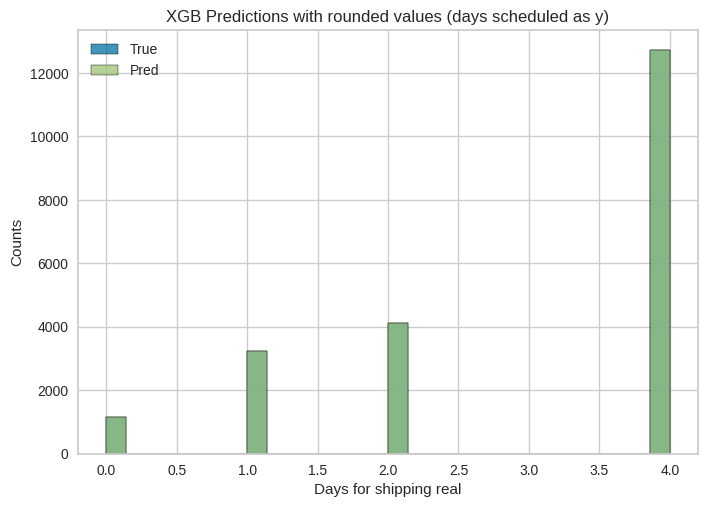

In [ ]:
import seaborn as sns
ax1 = sns.histplot(y_test, label = 'True')
sns.histplot(rounded_xgb_stratified_schedule, label = 'Pred')

plt.legend()
plt.xlabel('Days for shipping real')
plt.ylabel('Counts')
plt.title('XGB Predictions with rounded values (days scheduled as y)')

In [ ]:
explainer = shap.TreeExplainer(xgb_re)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


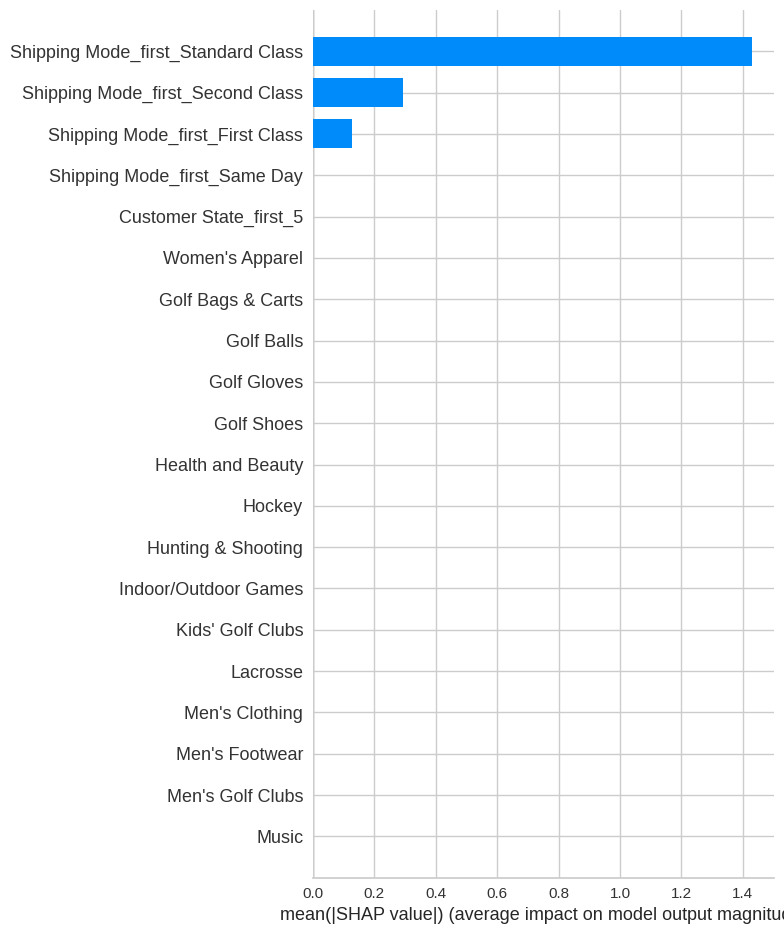

In [ ]:
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns, plot_type='bar', show=False)

plt.savefig('shap_plot2_schedule.png', bbox_inches='tight', dpi=300)